In [5]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)
directory_search_pattern = "careless_runs/" #directory in which to search for tabular outputs. 

This notebook is for calculating, compiling, and visualizing merging statistics. 

In [6]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.MLPL  = run_param.MLPL.astype( 'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

In [3]:
!pwd

/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/thermolysin_xfel


### Run scripts to calculate merging statistics

We calculate merging statistics with a set of scripts in `./scripts`.

In [ ]:
%%bash

sh ./scripts/unfriedelize_all.sh merge_1975*

In [2]:
%%bash

sh ./scripts/run_ccs.sh merge_1975*

./careless_runs/merge_19756566_21755_mono_cl3_mc1_grid_16
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/thermolysin_xfel/careless_runs/merge_19756566_21755_mono_cl3_mc1_grid_16
1
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/thermolysin_xfel/careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2

./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/thermolysin_xfel/careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/thermolysin_xfel/careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4

./careless_runs/merge_19756571_7049_mono_cl3_mc1_grid_5
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/thermolysin_xfel/careless_runs/merge_19756571_7049_mono_cl3_mc1_grid_5

./careless_runs/merge_197565

### Importing $CC_\text{pred}$

We now import overall CCpred, CC1/2, CCanom, and peak height values.

In [7]:
count=0
results_list=[]
params_list=[]
id_list=[]


for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        careless_params["seed"]=seed
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

### Importing $CC_\text{1/2}$

In [8]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('cchalf_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'cchalf_overall.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_cchalf=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

### Importing $CC_\text{anom}$

In [9]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccanom_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccanom_overall.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_ccanom=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

### Importing Zn peak height for each weighting scheme

We import the zinc peak height for each weighting scheme. 

In [10]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('peak_heights.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'peak_heights.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_peak_heights=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

In [11]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('peak_heights_W_dh.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'peak_heights_W_dh.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_peak_heights_W_dh=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

In [12]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('peak_heights_W_dh_d.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'peak_heights_W_dh_d.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_peak_heights_W_dh_d=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

In [13]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('peak_heights_W_dh_e.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'peak_heights_W_dh_e.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_peak_heights_W_dh_e=pd.concat(results_list)

./careless_runs/merge_19756569_4597_mono_cl3_mc1_grid_4
Read-in values of grid_id: 4,  job_id: 19756569,  seed: 4597
./careless_runs/merge_19756572_25334_mono_cl3_mc1_grid_6
Read-in values of grid_id: 6,  job_id: 19756572,  seed: 25334
./careless_runs/merge_19756573_9373_mono_cl3_mc1_grid_7
Read-in values of grid_id: 7,  job_id: 19756573,  seed: 9373
./careless_runs/merge_19756568_26316_mono_cl3_mc1_grid_3
Read-in values of grid_id: 3,  job_id: 19756568,  seed: 26316
./careless_runs/merge_19756575_29062_mono_cl3_mc1_grid_9
Read-in values of grid_id: 9,  job_id: 19756575,  seed: 29062
./careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11
Read-in values of grid_id: 11,  job_id: 19756592,  seed: 3864
./careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2
Read-in values of grid_id: 2,  job_id: 19756567,  seed: 7468
./careless_runs/merge_19756574_4835_mono_cl3_mc1_grid_8
Read-in values of grid_id: 8,  job_id: 19756574,  seed: 4835
./careless_runs/merge_19756599_24962_mono_cl3_mc1_grid_1

In [14]:
all_params.reset_index(drop=True,inplace=True)
#all_params.info()
all_params.head(10)

,MLPL,IL,DMIN,ITER,SEED,DW_list,rDW,RU,STDOF,PEF,grid_id,job_id,seed
0,10,2,1.8,30000,4597,"None,0",0.50000,1,32.0,0,4,19756569,4597
1,10,2,1.8,30000,25334,"None,0",0.87500,1,32.0,0,6,19756572,25334
2,10,2,1.8,30000,9373,"None,0",0.93800,1,32.0,0,7,19756573,9373
3,10,2,1.8,30000,26316,"None,0",0.00000,1,32.0,0,3,19756568,26316
4,10,2,1.8,30000,29062,"None,0",0.98440,1,32.0,0,9,19756575,29062
5,10,2,1.8,30000,3864,"None,0",0.99610,1,32.0,0,11,19756592,3864
6,10,2,1.8,30000,7468,NaN,-1.00000,1,32.0,0,2,19756567,7468
7,10,2,1.8,30000,4835,"None,0",0.96900,1,32.0,0,8,19756574,4835
8,10,2,1.8,30000,24962,"None,0",0.99976,1,32.0,0,15,19756599,24962
9,10,2,1.8,30000,21755,"None,0",0.99990,1,32.0,0,16,19756566,21755


In [15]:
all_results_ccpred.head()

,Unnamed: 0,file,Resolution Range (Å),bin,test,Spacegroup,CCpred,grid_id,job_id,seed
0,0,thl_1p8A_grid_predictions_0.mtz,34.35 - 1.80,0,Train,P 61 2 2,0.874501,4,19756569,4597
1,1,thl_1p8A_grid_predictions_0.mtz,34.35 - 1.80,0,Test,P 61 2 2,0.857199,4,19756569,4597
2,2,thl_1p8A_grid_predictions_1.mtz,34.35 - 1.80,0,Train,P 61 2 2,0.880116,4,19756569,4597
3,3,thl_1p8A_grid_predictions_1.mtz,34.35 - 1.80,0,Test,P 61 2 2,0.854651,4,19756569,4597
0,0,thl_1p8A_grid_predictions_0.mtz,34.35 - 1.80,0,Train,P 61 2 2,0.859448,6,19756572,25334


We clean each of the dataframes generated and then combine them together.

In [16]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','seed','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)','seed'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [17]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["delay"] = [name[-5] for name in all_results_ccpred.file]
all_results_ccpred["delay"]=all_results_ccpred["delay"].astype('int32')
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results_ccpred.head()

test
index                   30
file                    30
grid_id                 30
job_id                  30
Resolution Range (Å)    30
seed                    30
CCpred_test             30
CCpred_train            30
delay                   30
dtype: int64


test,index,file,grid_id,job_id,Resolution Range (Å),seed,CCpred_test,CCpred_train,delay
0,0,thl_1p8A_grid_predictions_0.mtz,2,19756567,34.35 - 1.80,7468,0.855255,0.871691,0
1,15,thl_1p8A_grid_predictions_1.mtz,2,19756567,34.35 - 1.80,7468,0.869396,0.884305,1
2,1,thl_1p8A_grid_predictions_0.mtz,3,19756568,34.35 - 1.80,26316,0.796374,0.832508,0
3,16,thl_1p8A_grid_predictions_1.mtz,3,19756568,34.35 - 1.80,26316,0.843694,0.852566,1
4,2,thl_1p8A_grid_predictions_0.mtz,4,19756569,34.35 - 1.80,4597,0.857199,0.874501,0


### Clean `cchalf`,`ccanom`, and `peak heights` tables for merging

In [18]:
all_results_peak_heights = all_results_peak_heights.drop(columns=["job_id","seed"])

for i,peak_table in enumerate([all_results_peak_heights_W_dh, 
                   all_results_peak_heights_W_dh_d, 
                   all_results_peak_heights_W_dh_e]):
    try:
        peak_table.drop(columns=["job_id","seed","CA 318","CA 319","CA 320","CA 321"], 
                                   inplace=True)
    except:
        pass
    
    all_results_peak_heights = all_results_peak_heights.merge(peak_table, 
                                                              suffixes=("",f"_{i}"),
                                                              on="grid_id")
    
all_results = all_results_ccpred.merge(all_results_peak_heights,on="grid_id")

In [19]:
all_results_ccanom = all_results_ccanom[["CCanom","grid_id","seed","Spacegroup","bin"]]
all_results_ccanom = all_results_ccanom.groupby(by=["seed","Spacegroup","bin"]).mean().reset_index(drop=True)
all_results_ccanom["grid_id"]=all_results_ccanom["grid_id"].astype("int32")


In [20]:
#all_results_cchalf1 = all_results_cchalf.groupby(by=["seed","Spacegroup","bin"]).agg({'CChalf':['mean','std']}).reset_index(drop=True)
all_results_cchalf1 = all_results_cchalf[["CChalf","grid_id","seed","Spacegroup","bin"]]
all_results_cchalf1 = all_results_cchalf1.groupby(by=["seed","Spacegroup","bin"]).mean().reset_index(drop=True)
all_results_cchalf1["grid_id"]=all_results_cchalf1["grid_id"].astype("int32")


In [21]:
all_results = all_results.merge(all_results_ccanom,on="grid_id")
all_results = all_results.merge(all_results_cchalf1,on="grid_id")

In [22]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 30 non-null     int64  
 1   file                  30 non-null     object 
 2   grid_id               30 non-null     int64  
 3   job_id                30 non-null     int64  
 4   Resolution Range (Å)  30 non-null     object 
 5   seed                  30 non-null     int64  
 6   CCpred_test           30 non-null     float64
 7   CCpred_train          30 non-null     float64
 8   delay                 30 non-null     int32  
 9   ZN 317                30 non-null     float64
 10  CA 318                30 non-null     float64
 11  CA 319                30 non-null     float64
 12  CA 320                30 non-null     float64
 13  CA 321                30 non-null     float64
 14  ZN 317_0              30 non-null     float64
 15  ZN 317_1              30 

In [25]:
df_param=all_params[['IL','MLPL','ITER','STDOF','PEF','rDW','RU','grid_id','job_id','seed']].copy()

for ix, row in df_param.iterrows():
    grid_id=int(row["grid_id"])
    job_id =int(row["job_id"])
    for column in df_param.columns:
        all_results.loc[(all_results["grid_id"]==grid_id) & (all_results["job_id"]==job_id), column] =\
        df_param.loc[(df_param["grid_id"]==grid_id) & (df_param["job_id"]==job_id),column].to_numpy()[0]

all_results=all_results.infer_objects()
all_results=all_results.sort_values(by=["grid_id"])

tmp=all_results.loc[(all_results["delay"]>-1),\
                      ["delay","CCpred_train","CCpred_test","ZN 317","CA 318","CA 319","CA 320","CA 321",
                       "ZN 317_1", "ZN 317_2","ZN 317_0","CCanom", "CChalf",
                       "grid_id","job_id","IL","MLPL","ITER","STDOF","PEF","rDW","RU"]].groupby(\
                      ["job_id","IL","MLPL","ITER","STDOF","PEF","rDW","RU"]).mean().reset_index().sort_values(by=["rDW"])
all_results_avg=tmp

# all_results_avg.set_index("grid_id",inplace=True)
#all_results_avg.style.background_gradient()
all_results_avg

,job_id,IL,MLPL,ITER,STDOF,PEF,rDW,RU,delay,CCpred_train,...,CA 318,CA 319,CA 320,CA 321,ZN 317_1,ZN 317_2,ZN 317_0,CCanom,CChalf,grid_id
1,19756567,2.0,10.0,30000.0,32.0,0.0,-1.00000,1.0,0.5,0.877998,...,5.152,2.346,4.508,2.049,22.322,23.761,23.841,0.121589,0.870986,2.0
2,19756568,2.0,10.0,30000.0,32.0,0.0,0.00000,1.0,0.5,0.842537,...,4.484,2.031,5.868,2.820,22.948,24.090,24.279,0.117449,0.869578,3.0
3,19756569,2.0,10.0,30000.0,32.0,0.0,0.50000,1.0,0.5,0.877308,...,4.604,3.438,5.728,2.941,23.188,24.549,24.769,0.121289,0.883372,4.0
4,19756571,2.0,10.0,30000.0,32.0,0.0,0.75000,1.0,0.5,0.875401,...,6.075,3.057,5.294,3.150,25.180,25.628,26.177,0.108736,0.892805,5.0
5,19756572,2.0,10.0,30000.0,32.0,0.0,0.87500,1.0,0.5,0.868634,...,6.798,3.429,5.229,2.973,24.914,25.135,25.800,0.127545,0.901746,6.0
6,19756573,2.0,10.0,30000.0,32.0,0.0,0.93800,1.0,0.5,0.878675,...,6.700,3.999,7.793,4.455,27.427,26.917,27.868,0.111246,0.909559,7.0
7,19756574,2.0,10.0,30000.0,32.0,0.0,0.96900,1.0,0.5,0.872710,...,7.420,3.989,7.127,3.964,27.523,26.732,27.883,0.127990,0.918598,8.0
8,19756575,2.0,10.0,30000.0,32.0,0.0,0.98440,1.0,0.5,0.853584,...,7.157,4.484,7.789,6.036,28.140,27.333,28.288,0.137743,0.922351,9.0
9,19756576,2.0,10.0,30000.0,32.0,0.0,0.99220,1.0,0.5,0.876949,...,7.073,4.735,8.548,5.887,28.797,27.798,28.785,0.127505,0.918739,10.0
10,19756592,2.0,10.0,30000.0,32.0,0.0,0.99610,1.0,0.5,0.877267,...,7.805,5.156,8.553,6.796,29.112,28.067,29.085,0.140073,0.922696,11.0


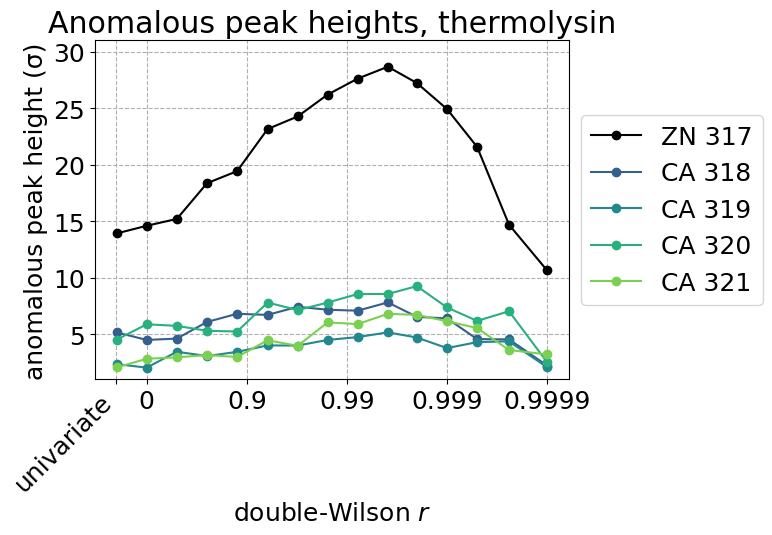

In [25]:
tmp=all_results_avg.copy()
tmp=tmp.sort_values(by=["rDW"])

n_atoms = 4
colors = plt.cm.viridis(np.linspace(0.3, 0.8, n_atoms))

fig,ax = plt.subplots(figsize=(8,5.7))
for atom in ["ZN 317"]:
    plt.plot(np.log10(1-tmp["rDW"]),tmp[atom],'ko-',label=f"{atom}")
for n,atom in enumerate(["CA 318","CA 319","CA 320","CA 321"]):
    plt.plot(np.log10(1-tmp["rDW"]),tmp[atom],'o-',color=colors[n],label=f"{atom}")
    


plt.grid(linestyle='--')
plt.title("Anomalous peak heights, thermolysin")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("anomalous peak height (σ)")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([1,31])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("peak heights.svg",bbox_inches="tight")
plt.show()

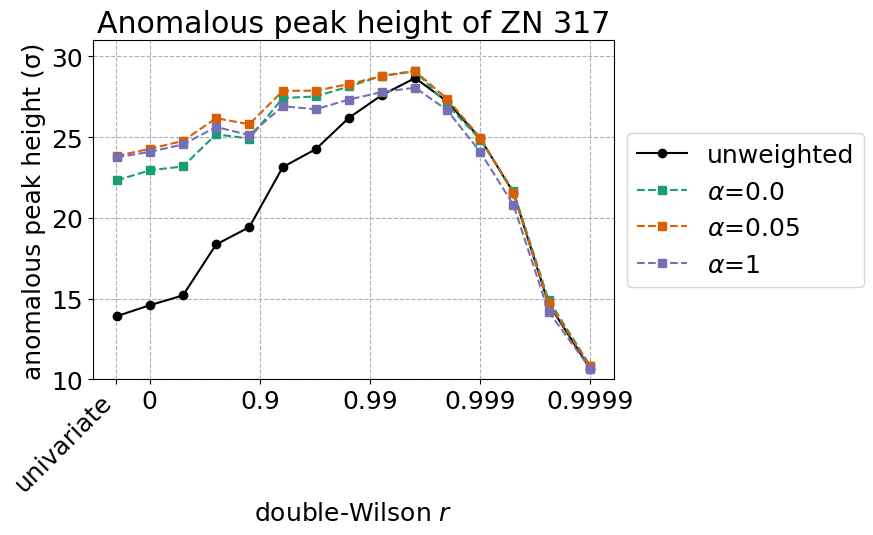

In [33]:
tmp=all_results_avg.copy()
tmp=tmp.sort_values(by=["rDW"])

n_atoms = 4
cbrewer_colors=["#1b9e77","#d95f02","#7570b3"]
alphas= [0.0,0.05,1]
fig,ax = plt.subplots(figsize=(9,5.7))
for atom in ["ZN 317"]:
    plt.plot(np.log10(1-tmp["rDW"]),tmp[atom],'ko-',label="unweighted")
for i,atom in enumerate(["ZN 317_1","ZN 317_0","ZN 317_2"]):
    plt.plot(np.log10(1-tmp["rDW"]),
             tmp[atom],
             's--',
             color=cbrewer_colors[i],
             label=r"$\alpha$="+str(alphas[i]))


plt.grid(linestyle='--')
plt.title("Anomalous peak height of ZN 317")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("anomalous peak height (σ)")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([10,31])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("peak heights-weighting.svg",bbox_inches="tight")
plt.show()

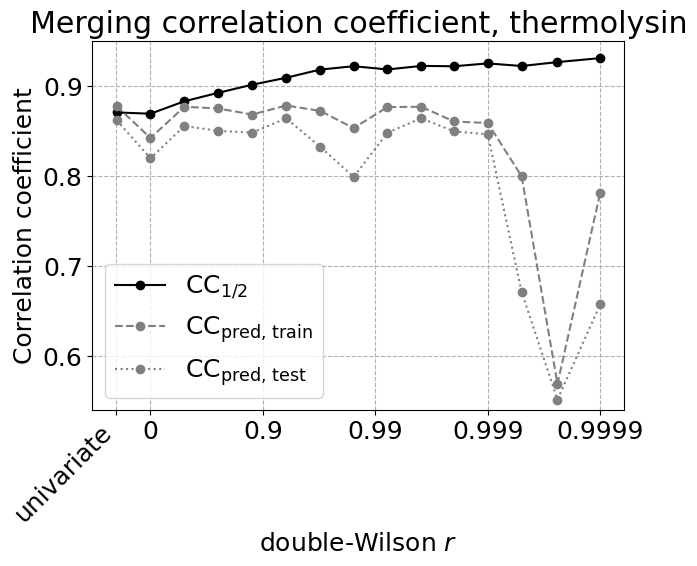

In [26]:
fig,ax = plt.subplots(figsize=(7,6))

plt.plot(np.log10(1-tmp["rDW"]),tmp["CChalf"],'ko-',label=r"CC$_\text{1/2}$")
plt.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_train"],'o--',color="gray",label=r"CC$_\text{pred, train}$")
plt.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_test"],'o:',color="gray",label=r"CC$_\text{pred, test}$")

plt.grid(linestyle="--")
plt.title("Merging correlation coefficient, thermolysin")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([0.54,0.95])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig("CCs.svg",bbox_inches="tight")
plt.show()

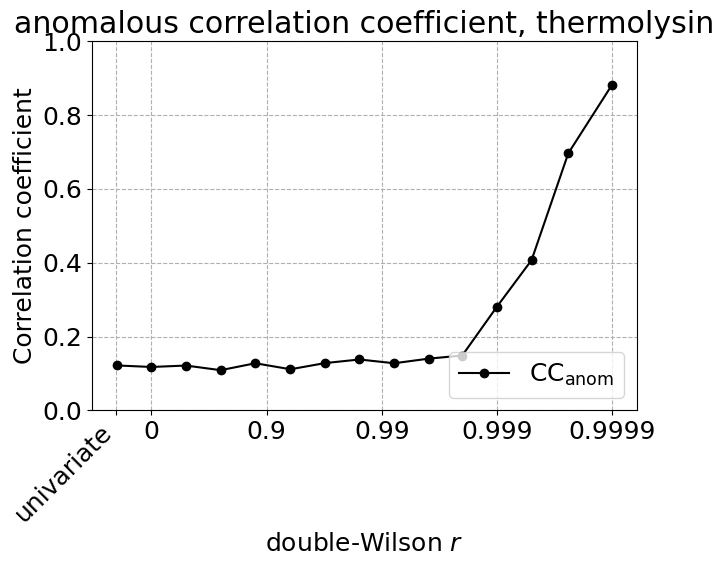

In [147]:
fig,ax = plt.subplots(figsize=(7,6))

plt.plot(np.log10(1-tmp["rDW"]),tmp["CCanom"],'ko-',label=r"CC$_\text{anom}$")

plt.grid(linestyle="--")
plt.title("anomalous correlation coefficient, thermolysin")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([0,1])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("CCanom.svg",bbox_inches="tight")
plt.show()

In [39]:
%%bash 

mkdir ./pymol
cd pymol
cp -r ../careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11/run_refinement/2tli_refine_001.pdb ./2tli_refine_001.pdb
cp -r ../careless_runs/merge_19756592_3864_mono_cl3_mc1_grid_11/run_omit_1/2tli_occ0_ions_refine_001.mtz omit_11.mtz
cp -r ../careless_runs/merge_19756567_7468_mono_cl3_mc1_grid_2/run_omit_1/2tli_occ0_ions_refine_001.mtz omit_2.mtz